In [27]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load test data

# CNN
test_path = r'/content/drive/MyDrive/DNN/graph_baseline/CNN_x_test_iter1.npy'
test_y_path = r'/content/drive/MyDrive/DNN/graph_baseline/CNN_y_test_iter1.npy'


x = np.load(test_path)
y = np.load(test_y_path)
y = y.reshape(y.shape[0],1)
df = np.hstack((x,y))
df = pd.DataFrame(df)
df = df.rename(columns={36000:'y'})


In [ ]:
# load train data
train_path = r'/content/drive/MyDrive/DNN/graph_baseline/CNN_x_train_iter1.npy'
train_y_path = r'/content/drive/MyDrive/DNN/graph_baseline/CNN_y_train_iter1.npy'
x_train = np.load(train_path)
y_train = np.load(train_y_path)
y_train = y_train.reshape(y_train.shape[0],1)
df_train = np.hstack((x_train,y_train))
df_train = pd.DataFrame(df_train)
df_train = df_train.rename(columns={36000:'y'})
# print(df_train['y'].value_counts())
df_train = df_train.loc[df_train['y'] == 0]

In [ ]:
# sample N data from each stage

df = pd.concat([df, df_train])

np.random.seed(seed=2022)

N = 300  # number of sample of each stage
dict_sample = {0: N, 1: N, 2: N, 3: N}

def stratified_sampling(group, dict_sample):
  name = group.name
  n = dict_sample[name]
  return group.sample(n=n)

df = df.groupby('y').apply(stratified_sampling, dict_sample)

In [ ]:
df['y'].value_counts()

0.0    300
1.0    300
2.0    300
3.0    300
Name: y, dtype: int64

In [ ]:
X_test = df.iloc[:,:-1].to_numpy()
y_test = df.iloc[:,-1].to_numpy()
np.save("/content/drive/MyDrive/DNN/graph_baseline/CNN_y_test", y_test)

In [ ]:
# Define recall, precision and f1 score (They removed these scores on tf 2.0 version)
def recall_model(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_model(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_model(y_true, y_pred):
    precision = precision_model(y_true, y_pred)
    recall = recall_model(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# CNN
model_path = r'/content/drive/MyDrive/DNN/graph_baseline/CNN_model_iter1.h5'
model = keras.models.load_model(model_path, custom_objects={'recall_model': recall_model, 'precision_model': precision_model, 'F1_model': F1_model })

In [ ]:
list=[]  # predictions for each test data
layer = []

for i in range(0, X_test.shape[0]):  # X_test.shape[0]
  X=X_test[i:(i+1), :]
  predictions = model.predict(X)
  list.append(np.argmax(predictions[0]))
  extractor = keras.Model(inputs=model.inputs,outputs=[layer.output for layer in model.layers])
  features = extractor(X)
  a=features[-2].numpy()
  a=a.flatten()
  layer.append(a)
  if (i+1) % 400 == 0:
    print(i)
    np.save("/content/drive/MyDrive/DNN/graph_baseline/CNN_feature_"+str((i+1)//400), layer)
    layer = []

np.save("/content/drive/MyDrive/DNN/graph_baseline/CNN_list", list)


# features_vb=[]
# features_vb.append(layer)
# np.save("/content/drive/MyDrive/DNN/graph_baseline/CNN_feature", layer)



399
799
1199


# After saving CNN_feature

In [ ]:
# del df_train

In [ ]:
layer = ''
for i in range(1, 4):
  feature_path = "/content/drive/MyDrive/DNN/graph_baseline/CNN_feature_"+str(i)+'.npy'
  tmp = np.load(feature_path)
  if layer == '':
    layer = tmp
  else:
    layer = np.vstack((layer, tmp))

del tmp

y_test = np.load("/content/drive/MyDrive/DNN/graph_baseline/CNN_y_test.npy")
list = np.load("/content/drive/MyDrive/DNN/graph_baseline/CNN_list.npy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


KeyboardInterrupt: ignored

In [ ]:
print(y_test.shape)
print(list.shape)
print(layer.shape)

(1200,)
(1200,)
(1200, 1152000)


In [ ]:
# dimensionality reduction

# buf=np.array(layer)
buf = layer
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(buf)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
y_test=y_test.reshape(y_test.shape[0],1)
# list=np.array(list)
list=list.reshape(list.shape[0],1)
tsne_result=np.hstack((tsne_result, y_test))
np.save("/content/drive/MyDrive/DNN/graph_baseline/CNN_tsne", tsne_result)


# check the predictions
for i in range(0,tsne_result.shape[0]):
  if tsne_result[i][2]==list[i]:
    list[i]=0
  else:
    list[i]=1
# map (0,1) to (Correct,Error) and record in list correct[]
correct=[]
size=[]  # point size in graph
for i in range(0, len(list)):
  if list[i]==0:
    correct.append("Correct")
  else:
    correct.append("Error")
  size.append(1)

df = pd.DataFrame(tsne_result, columns = ['x','y', 'Stages'])
df['Correctness'] = correct
df['size'] = size
df.to_csv(r'/content/drive/MyDrive/DNN/graph_baseline/CNN_df.csv', index=False)
df


,x,y,Stages,Correctness,size
0,-3.829496,23.079618,0.0,Correct,1
1,-3.707804,-14.539579,0.0,Correct,1
2,-0.565871,-12.943517,0.0,Correct,1
3,-0.974301,-12.831744,0.0,Correct,1
4,-5.709312,27.775263,0.0,Correct,1
...,...,...,...,...,...
1195,-6.150103,-12.962475,3.0,Error,1
1196,-2.225509,24.635332,3.0,Error,1
1197,27.502680,4.437421,3.0,Correct,1
1198,-1.048745,-9.512840,3.0,Error,1


# Draw the plot

In [29]:
df_backup = pd.read_csv(r'/content/drive/MyDrive/DNN/graph_baseline/CNN_df.csv')

In [30]:
df = df_backup.copy()
df = df.loc[(df.x < 10) & (df.y < 40)]
df.shape

(1153, 5)

In [36]:
df = df.sample(frac=1)
df['Stages'] = df['Stages'].astype(int)
df['Stages'].value_counts()

0    299
2    290
1    285
3    279
Name: Stages, dtype: int64

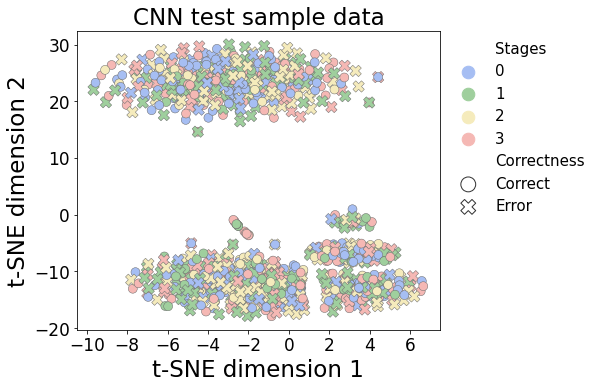

In [38]:
colors = ['#A6BEF3', '#9FCF9D', '#F5EBBC', '#F5B8B4']

plt.figure(figsize=(6.5,5.5))
g=sns.scatterplot(
    x="x", y="y",
    hue="Stages",
    # palette=['#6E9ECE', '#E6928F', '#84574D', '#76ba80'],
    palette=colors,
    # palette="coolwarm",
    data=df,
    legend=False,
    size="Correctness",
    sizes=(130, 80),
    style="Correctness",
    # edgecolor=['grey'],
    # alpha=1,
    # linewidth=0.3

)

g=sns.scatterplot(
    x="x", y="y",
    hue="Stages",
    # palette=['#6E9ECE', '#E6928F', '#84574D', '#76ba80'],
    palette=colors,
    # palette="coolwarm",
    data=df,
    # legend=False,
    size="Correctness",
    sizes=(130, 80),
    style="Correctness",
    edgecolor='#6F6F6F',
    alpha=1,
    linewidth=0.5
)


# Set x-axis label
plt.xlabel('t-SNE dimension 1', fontsize=23)
# Set y-axis label
plt.ylabel('t-SNE dimension 2', fontsize=23)
plt.title("CNN test sample data", fontsize=23)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# Set the legend
handles, labels = g.get_legend_handles_labels()
for h in handles[-2:]:
  h.set_facecolor('none')
  h.set_sizes([50])
plt.legend(fontsize=15, loc = 2, bbox_to_anchor = (1,1.01), markerscale=2.1, frameon=False)

(array([-40., -20.,   0.,  20.,  40.,  60.,  80.]),
 <a list of 7 Text major ticklabel objects>)

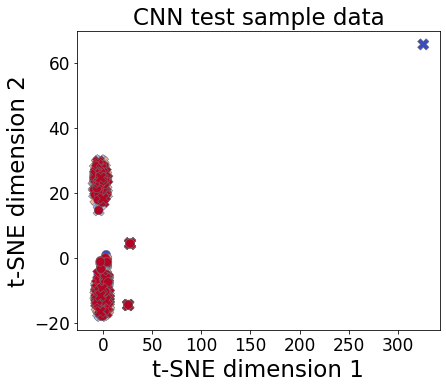

In [ ]:
#@title
plt.figure(figsize=(6.5,5.5))
g=sns.scatterplot(
    x="x", y="y",
    hue="Stages",
    # palette=['#6E9ECE', '#E6928F', '#84574D', '#76ba80'],
    palette="coolwarm",
    data=df,
    legend=False,
    size="Correctness",
    sizes=(130, 80),
    style="Correctness",
    # edgecolor=['grey'],
    # alpha=1,
    # linewidth=0.3

)

g=sns.scatterplot(
    x="x", y="y",
    hue="Stages",
    # palette=['#6E9ECE', '#E6928F', '#84574D', '#76ba80'],
    palette="coolwarm",
    data=df,
    legend=False,
    size="Correctness",
    sizes=(130, 80),
    style="Correctness",
    edgecolor='#6F6F6F',
    alpha=1,
    linewidth=0.5
)


# Set x-axis label
plt.xlabel('t-SNE dimension 1', fontsize=23)
# Set y-axis label
plt.ylabel('t-SNE dimension 2', fontsize=23)
plt.title("CNN test sample data", fontsize=23)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Backup

In [ ]:
df[36000].value_counts()

3.0    628
2.0    455
1.0    444
0.0     78
Name: 36000, dtype: int64

In [ ]:
df[36000].value_counts()

3.0    2454
2.0    1963
1.0    1730
0.0     269
Name: 36000, dtype: int64

In [ ]:
269+78

347

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical
import pandas as pd

In [ ]:
np.random.shuffle(y)

In [ ]:
y_train=pd.DataFrame(data=y)

one_hot_train_labels = to_categorical(y_train)

In [ ]:
y_train

,0
0,1.0
1,3.0
2,3.0
3,2.0
4,3.0
...,...
6411,2.0
6412,1.0
6413,3.0
6414,2.0


In [ ]:
one_hot_train_labels[3]

array([0., 0., 1., 0.], dtype=float32)

In [ ]:
csv_train = r'/content/drive/MyDrive/DNN/graph_baseline/DNN_x_train_iter1.npy'
x = np.load(csv_train)

In [ ]:
csv_train_y = r'/content/drive/MyDrive/DNN/graph_baseline/DNN_y_train_iter1.npy'
y = np.load(csv_train_y)

In [ ]:
model_path = r'/content/drive/MyDrive/DNN/graph_baseline/DNN_model_iter1.h5'
model = keras.models.load_model(model_path, custom_objects={'recall_model': recall_model, 'precision_model': precision_model, 'F1_model': F1_model })

In [ ]:
predictions = []
y_predict = []

for i in range(x.shape[0]):
  X=x[i:(i+1), :]
  predictions.append(model.predict(X)[0])  # output of softmax
  y_predict.append(np.argmax(predictions[i]))  


In [ ]:
df_map = {'y_train': y, 'y_predict': y_predict}
df = pd.DataFrame(df_map)

def correctness(x,y):
  if x == y:
    return 1  # correct
  else:
    return 0

df['correctness'] = df.apply(lambda x: correctness(x['y_train'], x['y_predict']), axis=1)

In [ ]:
df.groupby('correctness').count()

,y_train,y_predict
correctness,,
0,2053,2053
1,4363,4363


In [ ]:
4363/(2053+4363)

0.6800187032418953

In [ ]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(y, y_predict)
df_confusion = pd.DataFrame(C,index=[0,1,2,3],columns=[0,1,2,3])

In [ ]:
df_confusion

,0,1,2,3
0,97,27,33,112
1,0,275,827,628
2,0,19,1653,291
3,0,1,115,2338


In [ ]:
# path = r'/content/drive/MyDrive/DNN/graph_baseline'
# print(os.listdir(path))

['Baseline Input Data Reduced Size.mat', 't_sne_kfold_layer1.ipynb', 'test.ipynb', "Ziggy's DNN Baseline v2.ipynb”的副本", 'graph_baseline.ipynb', 'DNN_y_train_iter1.csv', 'DNN_x_train_iter1.csv', 'DNN_model_iter1.h5']


In [ ]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_ca

In [ ]:
test_loss=[]
train_loss=[]
test_acc=[]
train_acc=[]
test_auc=[]
train_auc=[]
for train_index, test_index in kfold.split(X):
	#print('train: %s, test: %s' % (train_index, test_index))
  X_train= X[train_index]
  y_train=y[train_index]
  X_test=X[test_index]
  y_test=y[test_index]

  X_train=pd.DataFrame(data=X_train)
  y_train=pd.DataFrame(data=y_train)
  y_test=pd.DataFrame(data=y_test)
  X_test=pd.DataFrame(data=X_test)
  one_hot_train_labels = to_categorical(y_train)
  one_hot_test_labels = to_categorical(y_test)
  

  # DNN
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(36000,)))
  model.add(layers.BatchNormalization())
  model.add(Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(4, activation='softmax'))


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy','AUC'])
  history = model.fit(X_train, one_hot_train_labels, epochs = 200, batch_size = 64, validation_data=(X_test, one_hot_test_labels))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_loss.append(loss)
  test_loss.append(val_loss)
  train_acc_1=history.history['accuracy']
  val_acc = history.history['val_accuracy']
  test_acc.append(val_acc)
  train_acc.append(train_acc_1)
  a=history.history['auc']
  b=history.history['val_auc']
  test_auc.append(b)
  train_auc.append(a)

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="mse",
    # loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_regression.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_mae", patience=100)

# Train the model, doing validation at the end of each epoch
epochs = 500
model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_test,y_test),
    epochs=epochs,
    shuffle=True,
    verbose=1,
    batch_size=32,
    callbacks=[checkpoint_cb, early_stopping_cb],
)